# Distance Analysis

В этом модуле рассматриваются расстояния защитников от нападающих на протяжении всего игрового момента. Для подсчета расстояния используется евклидово расстояние от защитника до каждого нападающего игрока. Такой способ позволяет в каждый момент времени определить насколько близко был защитник.

*Для анализа будем использовать pandas, numpy, matplotlib*

In [6]:
import pandas as pd
import math 
import numpy as np
import itertools as it
from collections import defaultdict
import csv
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

Для обработки нам понадобятся таблицы plays, games, players. Предположение таково: после того, как ресивер поймал мяч он оказывается в окружении защитников. Количество ярдов, которое сможет пробежать ресивер, определяет счет игры. Что же влияет на это?
Именно расположение защитников в этот момент сможет нам рассказть о ходе дальнейшей игры. Чем ближе оказываются защитники к ресиверу в момент ловли паса, тем меньше ярдов он сможет набрать. А следовательно лучше сработает защита. Для анализа этих данных предлагается использовать расстояния до ресивера от каждого из защитников: 

In [2]:
players = pd.read_csv('nfl-big-data-bowl-2021/players.csv')
games = pd.read_csv('nfl-big-data-bowl-2021/games.csv')
plays = pd.read_csv('nfl-big-data-bowl-2021/plays.csv')

In [3]:
def findClosest(players, football):
    distances = []
    for index, row in players.iterrows():
        distance = np.linalg.norm(np.subtract([football.x.values[0], football.y.values[0]], [row.x, row.y]))
        distances.append((row.nflId, distance))
    closest_id, closest_dist = sorted(distances, key=lambda t: t[1])[0]
    return closest_id, closest_dist

In [4]:
closest_defender = defaultdict(dict)

In [ ]:
for week_number in range(1, 18):
    print("\r{0}/{1}".format(week_number, 17), end="")
    game_week = games[games['week'] == week_number]
    week_path = 'nfl-big-data-bowl-2021/week' + str(week_number) + '.csv'
    current_week_data = pd.read_csv(week_path)
    
    for _, game_row in game_week.iterrows():
        id_game = game_row.gameId
        cur_data = current_week_data[current_week_data['gameId'] == id_game]
        play_game = plays[plays['gameId'] == id_game]
        
        for _, play_row in play_game.iterrows():
            if play_row.passResult == 'C':
                id_play = play_row.playId
                cur_play_data = cur_data[cur_data['playId'] == id_play]
                play_events = pd.unique(cur_play_data.event)                     
                if 'pass_outcome_caught' in play_events:
                    try:
                        offense = cur_play_data[cur_play_data['position'] == 'QB'].team.values[0]
                        defense = ('home' if offense == 'away' else 'away')
                    except:
                        continue
                    pc_data = cur_play_data[cur_play_data['event'] == 'pass_outcome_caught']
                    frame_caught = pc_data.iloc[0]['frameId']
                    last_frame = cur_play_data.iloc[-1]['frameId']
                    football1 = pc_data[pc_data['team'] == 'football']
                    football2 = cur_play_data[
                        (cur_play_data['frameId'] == last_frame) & 
                        (cur_play_data['team'] == 'football')]
                    offensive_players = pc_data[pc_data['team'] == offense]
                    defensive_players = pc_data[pc_data['team'] == defense]
                    
                    try:
                        closest1 = findClosest(offensive_players, football1)[0]
                    except:
                        continue
                        
                    receiver = pc_data[pc_data['nflId'] == closest1]
                    try:
                        closest_id, closest_dist = findClosest(defensive_players, receiver)
                    except:
                        continue
                        
                    if football1.playDirection.values[0] == 'left':
                        yards = football1.x.values[0] - football2.x.values[0]
                    elif football1.playDirection.values[0] == 'right':
                        yards = football2.x.values[0] - football1.x.values[0]

                    closest_defender[id_game][id_play] = (closest_dist, closest_id, frame_caught, last_frame, yards)

11/17

In [43]:
with open('closest_defender.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['gameId', 'playId', 'closest_distance', 'nflId', 'frame_start', 'frame_end', 'yards', 'playResult'])
    for GAME in closest_defender:
        for PLAY, val in closest_defender[GAME].items():
            cur_play = plays[(plays['gameId'] == GAME) & (plays['playId'] == PLAY)]
            writer.writerow([GAME, PLAY, val[0], val[1], val[2], val[3], val[4], cur_play.iloc[0]['offensePlayResult']])

Преобразуем выборку в pandas DataFrame

In [8]:
dist_df = pd.read_csv('closest_defender.csv')

In [9]:
dist_df['frames'] = dist_df.frame_end - dist_df.frame_start

In [10]:
dist_df

,gameId,playId,closest_distance,nflId,frame_start,frame_end,yards,playResult,frames
0,2018090600,75,1.081712,79848,52,59,2.15,10,7
1,2018090600,190,0.523927,2552689,62,73,6.05,33,11
2,2018090600,492,6.770089,2552315,61,100,32.80,26,39
3,2018090600,521,1.535839,2558175,55,58,0.44,3,3
4,2018090600,992,2.594706,2555255,52,68,1.45,1,16
...,...,...,...,...,...,...,...,...,...
9201,2018123014,3845,2.773085,2553536,47,59,2.58,1,12
9202,2018123014,4088,3.647821,2561006,52,68,5.90,5,16
9203,2018123014,4181,0.870976,2559934,42,76,2.22,6,34
9204,2018123014,4206,4.379052,1037374,43,98,42.96,43,55


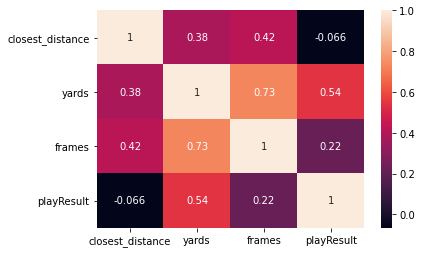

In [11]:
cols = ['closest_distance','yards', 'frames', 'playResult']
hm = sns.heatmap(dist_df[cols].corr(),
                 cbar=True,
                 annot=True)

In [12]:
m1 = smf.ols('yards ~ closest_distance + frames', 
             data=dist_df).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                  yards   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     5385.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        22:47:06   Log-Likelihood:                -26972.
No. Observations:                9206   AIC:                         5.395e+04
Df Residuals:                    9203   BIC:                         5.397e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.7164      0.094  

Судя по summary, мы получили неплохую модель. Стандартная ошибка полчаетмя меньше 1 для каждого параметра, высокое значение F-test и R^2 около 0,5 говорит о достаточной точности результатов. 

Однако при выполнении предсказания пройденных ярдов, необходимо учитывать и другие факторы. Один из способов - ориентация игрока, для уменьшения разброса значений. Так же один из вариантов дальшейшего улучшения - пересчет игрового счета для каждого игрока с использованием вероятностей успеха выполнения защиты.

In [ ]:
fig = px.scatter_3d(dist_df, x='closest_distance', y='frames', z='yards', color='yards', size_max=1, opacity=0.7)
fig.show()

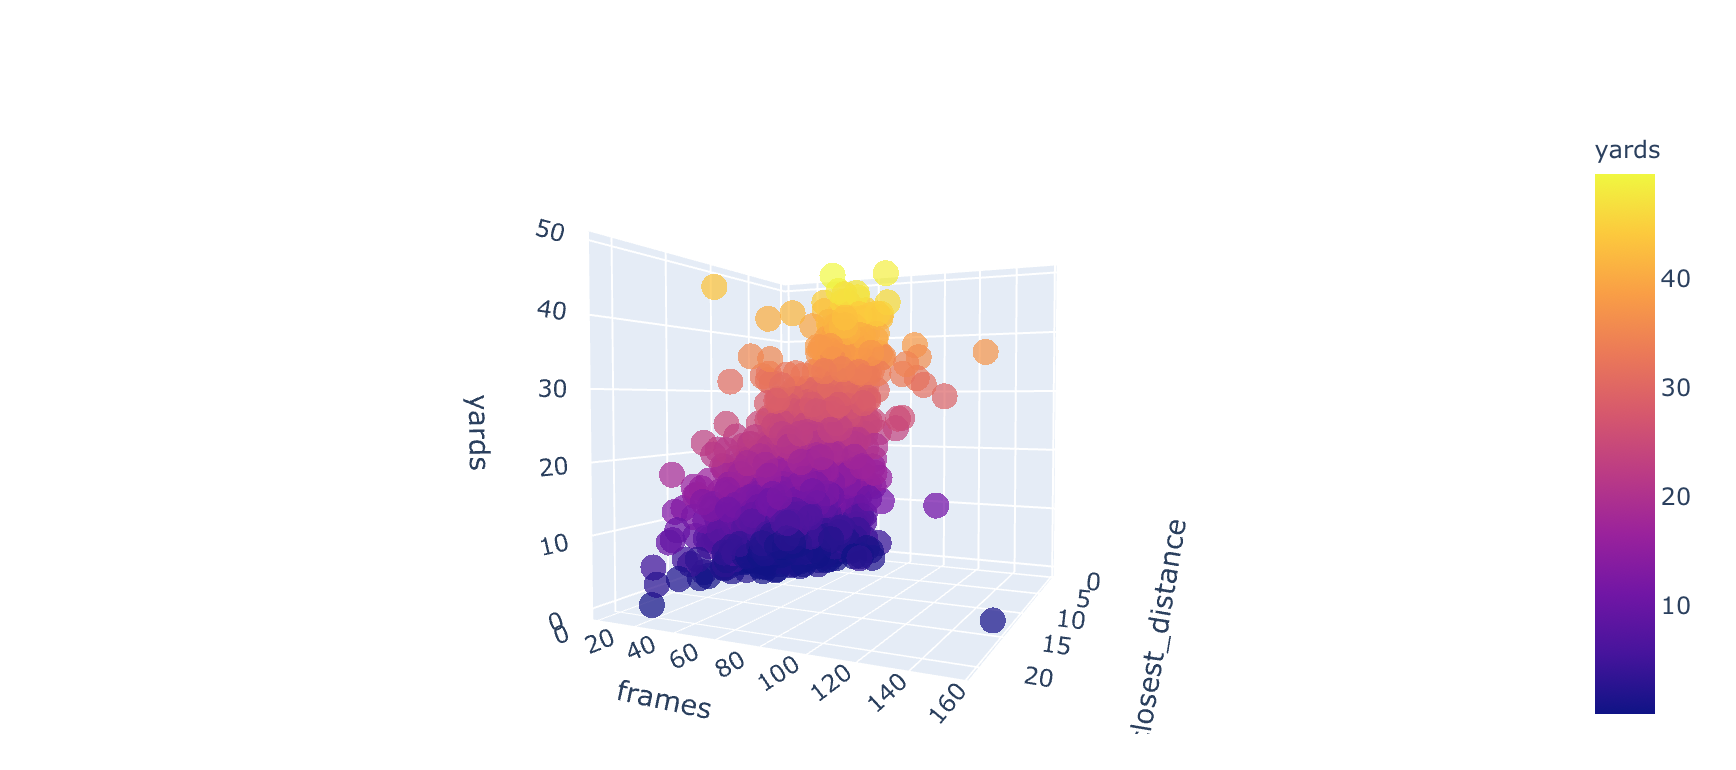

In [14]:
dist_df['predict'] = m1.predict(dist_df[['closest_distance', 'frames']])

Text(0.5, 1.0, 'Yards vs Predict graph')

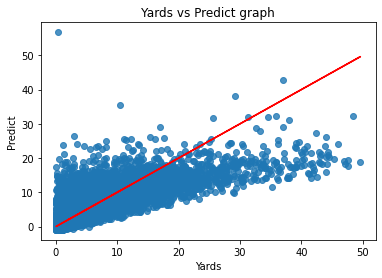

In [15]:
plt.scatter(dist_df.yards, dist_df.predict, alpha=0.8)
plt.plot(dist_df.yards, dist_df.yards, 'r')
plt.xlabel('Yards')
plt.ylabel('Predict')
plt.title('Yards vs Predict graph')

In [ ]:
fig2 = px.scatter_3d(dist_df, x='closest_distance', y='frames', z='predict', color='predict', size_max=1, opacity=0.7)
fig2.show()

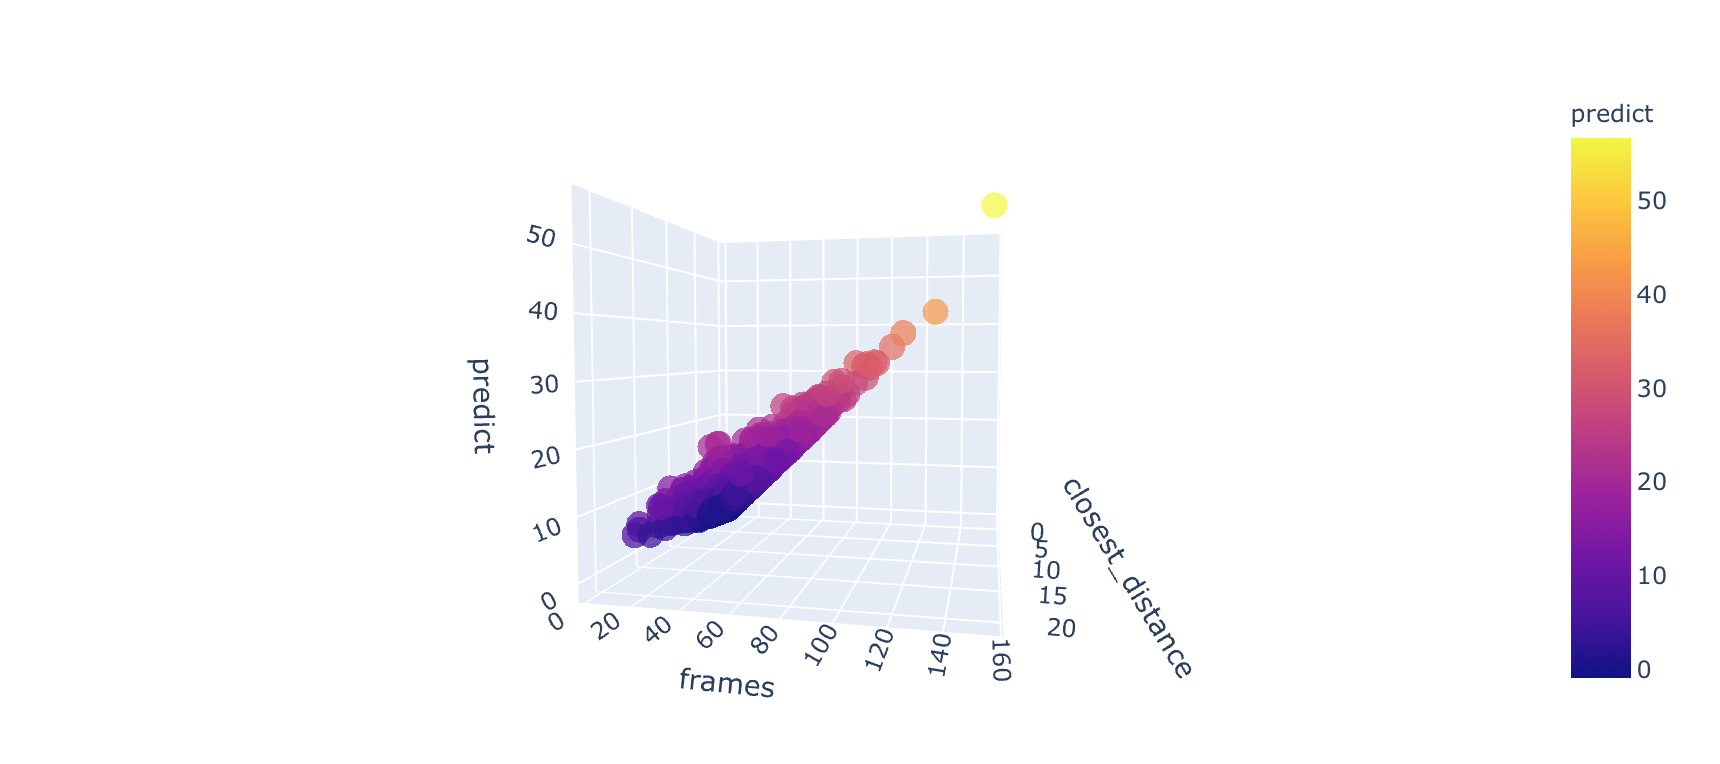

Таким образом мы вполне можем предсказать, как далеко сможет пройти ресивер. Проранжируем игроков по среднему расстоянию за все игры.

In [71]:
players_id = dist_df.nflId.unique()
top2 = {}
for each in players_id:
    all_df = dist_df[dist_df["nflId"] == each]
    top2[each] = np.mean(all_df.closest_distance) 


In [72]:
top_df2 = pd.DataFrame.from_dict(top2, orient='index', columns=['mean'])
top_df2['nflId'] = top_df2.index

In [73]:
clustered = pd.read_csv('clustering.csv')
# clustered = clustered.loc[(clustered['points_cnt'] == 2) | (clustered['points_cnt'] == 6) | (clustered['points_cnt'] == 7)]

In [74]:
result = pd.merge(clustered, top_df2, on="nflId")

In [75]:
sorted_players = result.sort_values(["mean"], ascending = (True))

In [76]:
sorted_players.loc[:, 'position':'mean'].head(10)

,position,displayName,points,cnt,BMI,points_cnt,points_bmi,mean
344,LB,Bruce Irvin,-24,9,31.244444,5,6,0.434166
460,CB,Josh Robinson,9,1,28.693878,5,6,0.780577
417,ILB,Bruce Carter,71,7,30.810811,6,6,0.832464
457,CB,Cornell Armstrong,52,5,25.087770,5,7,0.838839
312,DB,Dane Cruikshank,22,3,27.571214,5,7,1.018332
40,CB,Maurice Canady,24,2,25.460499,5,7,1.032473
470,DB,Obi Melifonwu,5,1,27.263158,5,7,1.067801
39,CB,Anthony Averett,43,5,24.823249,5,7,1.116288
379,DB,Keion Crossen,97,7,26.541837,6,7,1.117027
414,CB,Quenton Meeks,90,6,27.571214,6,7,1.174337


Как видим, самыми интересными для нас оказались игроки позиций LB, CB, DB. Именно они закрывают ресиверов и именно они оказываются на пути ресивера после поимки мяча. Лучшим оказакался **Bruce Irvin** принесший -24 очка команде защиты (чем меньше - тем лучше, основываемся на очках полученных командой атаки). Среднее расстояние которое он держал за период игр 2018 года - около 0.5 ярда. Меньше даже, чем полметра!

## Другой подход 

Другой алгоритм смотрит на все расстояния защитников до ближайшего атакующего в каждый момент времени. Такой подход гораздо тяжелее, выполнение такого кода на большом датасете занимает длительное время. Однако из этого тоже можно выделить интересную информацию.

Общий алгоритм подсчета расстояний таков:

1. выбираем время
2. берем информацию о кадре в выбранное время
3. вычисляем для каждого защитника расстояние до каждого атакующего
4. берем наименьшее расстояние
5. идем к пункту 1.

In [ ]:
using_df = df.loc[df['team'] != 'football']
using_df = using_df.sort_values(['time','frameId'])
using_df['dist_enemy'] = [0.0 for _ in range(len(using_df))]

progress = 0
times = sorted(using_df.time.unique())

for each in times:
    current_df = using_df.loc[using_df['time'] == each]
    frame_df = current_df.frameId.unique()[0]
    for index, each_player in current_df.iterrows():
        progress += 1
        print("\r{0}/{1}".format(progress,len(using_df)), end="")
        my_nflId = each_player.nflId
        defender = each_player.defender
        if defender == 0:
            continue
        dist = []
        for index2, each_opp in current_df.iterrows():
            if each_opp.nflId != my_nflId and each_opp.defender != defender:
                dx = abs(each_player.x - each_opp.x)
                dy = abs(each_player.y - each_opp.y)
                counted = math.sqrt(dx*dx + dy*dy)
                dist.append(counted)
        if dist:
            using_df.at[index,'dist_enemy'] = min(dist)

Воспользуемся результатом посчитаном на 1-17 неделях. Этот датафрейм получили самостоятельно.

In [39]:
using_df = pd.read_csv('week1-17.csv')

Выберем данные по ролям в команде.
Основными категориями защитников являются **Line Backers**, **Defensive Ends** и **Defensive Backs**
Поэтому выберем игроков которые имеют роль CB, SS, DE, LB (OLB + MLB)

**Safety** хоть и относятся вместе с **Corner Back** к задним защитникам, однако на поле ведут себя немного иначе.

Давайте проверим это.

In [40]:
using_df = using_df.sort_values(["time"], ascending = (True))
cornerback = using_df[using_df['position'] == 'CB']
linebacker = using_df[(using_df['position'] == 'LB') | (using_df['position'] == 'MLB') | (using_df['position'] == 'OLB')]
safety = using_df[(using_df['position'] == 'SS') | (using_df['position'] == 'FS')]

In [48]:
def plot_dist(df):
    frames = {'frameId': [], 'dist_enemy': []}
    sorted_frames = df.frameId.unique()
    for frame in sorted(sorted_frames):
        cur_frame = df.loc[df['frameId'] == frame]
        y_mean = numpy.mean(cur_frame.dist_enemy)
        frames['frameId'].append(frame)
        frames['dist_enemy'].append(y_mean)
        if frame == 80:
            break
    frame_df = pd.DataFrame(frames, columns = ['frameId', 'dist_enemy'])
    plt.plot(frame_df.frameId, frame_df.dist_enemy)
    plt.xlabel('Time (frame)')
    plt.ylabel('Distance (yard)')

Изобразим основную тактику игроков по расстояниям

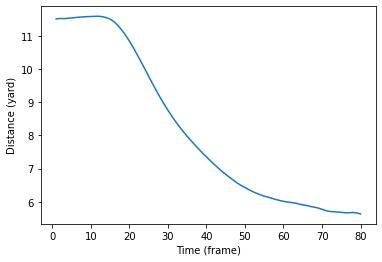

In [49]:
plot_dist(safety)

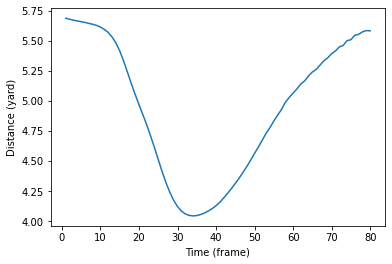

In [43]:
plot_dist(linebacker)

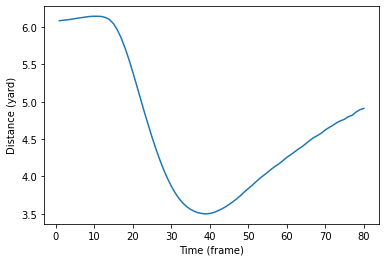

In [44]:
plot_dist(cornerback)

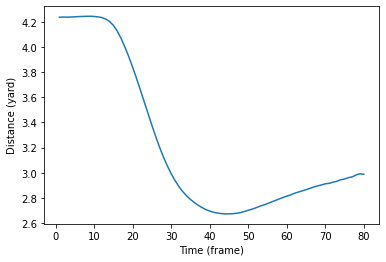

In [45]:
plot_dist(using_df)

Для наглядности приведу одну из картинок с формацией команд

![Positions](http://www.marginalrevolution.com/photos/uncategorized/2008/07/18/positions3.png)

Как видно safety стоят всегда сзади и на протяжении игры редко приближаются вплоную, однако мониторят движение противника. Linebacker обычно в начале розыгрыша прорывается к квотербэку, что мы видим на рисунке. Дальше их роль заключается в мониторинге игры - обычно они пытаются взять разыгрывающего в "мешок" и после уже не могут играть (касание земли). И наконец CB бегут с соперниками удерживая короткую дистанцию. 

Последний график построен по всем данным защитников и здесь отчетливо видна тактика защиты - приближение и закрытие соперника на близком (~2-3 ярда) расстоянии.

Тут стоит уточнить, что основная часть розыгрышей проходит за первые 50-70 кадров. Розыгрыш всегда на 11 кадре. 

In [50]:
unique_players = using_df.nflId.unique()

In [162]:
top = {'nflId': [], 'maxDist': [], 'minDist': [], 'average': [], 'enter': []}

Соберем топ по расстояниям для игроков

In [165]:
progress = 1
for each in unique_players:
    print("\r{0}/{1}".format(progress,len(unique_players)), end="")
    progress += 1
    tar = using_df[using_df['nflId'] == each]
    if tar.defender.unique()[0] == 0:
        continue
    max_in = len(tar.playId.unique())
    plays = {'dist_enemy_avg': [], 'dist_enemy_min': [], 'dist_enemy_max': []}
    for game in tar.gameId.unique():
        cur_game = tar.loc[tar['gameId'] == game]
        for play in cur_game.playId.unique():
            cur_play = cur_game.loc[cur_game['playId'] == play]
            cur_play = cur_play[(cur_play['frameId'] > 30) | (cur_play['frameId'] < 60)]
            plays['dist_enemy_avg'].append(numpy.mean(cur_play.dist_enemy))
            plays['dist_enemy_min'].append(numpy.min(cur_play.dist_enemy))
            plays['dist_enemy_max'].append(numpy.max(cur_play.dist_enemy))
    p_df = pd.DataFrame(plays, columns = ['dist_enemy_avg', 'dist_enemy_min', 'dist_enemy_max'])
    top['nflId'].append(each)
    top['maxDist'].append(numpy.max(p_df.dist_enemy_max))
    top['minDist'].append(numpy.min(p_df.dist_enemy_min))
    top['average'].append(numpy.mean(p_df.dist_enemy_avg))
    top['enter'].append(max_in)

1302/1303

In [87]:
top_df.to_csv('top.csv', encoding='utf-8', index=False)

In [4]:
top_df = pd.read_csv('top.csv')

Далее соединим эти данные с таблицей игроков и посчитанными очками которые они принесли - чем меньше очки, тем лучше для команды защиты. Для анализа будем использовать данные о кластеризации полученные в первой части отчета.

In [5]:
players_cnt = pd.read_csv('clustering.csv')

In [6]:
players_cnt['maxDist'] = 0
players_cnt['minDist'] = 0
players_cnt['average'] = 0
players_cnt['enter'] = 0

In [7]:
for index, each in top_df.iterrows():
    ind = players_cnt.loc[players_cnt['nflId'] == int(each['nflId'])]
    if ind.empty:
        continue
    ind = ind.index[0]
    players_cnt.loc[ind, 'maxDist'] = each['maxDist']
    players_cnt.loc[ind, 'minDist'] = each['minDist']
    players_cnt.loc[ind, 'average'] = each['average']
    players_cnt.loc[ind, 'enter'] = each['enter']

In [8]:
players_cnt.to_csv('top_players.csv', encoding='utf-8', index=False)

Для построения графика плотности уберем нулевые значения из таблиц - для этих игроков нет данных

In [9]:
defenders = players_cnt.dropna()
sorted_players = defenders.sort_values(["points", "minDist", "average"], ascending = (True, True, True))
sorted_players.to_csv('top_players_sorted.csv', encoding='utf-8', index=False)

Этот код написан на языке R, график выглядит лучше
```
defence_df <- sorted_players[sorted_players$enter > 0.0,]

p2 <- ggplot(defence_df, aes(as.factor(category), average)) +
  geom_point(mapping=aes(colour=as.factor(position)), position='jitter', alpha=0.5) +
  geom_boxplot(mapping=aes(group=as.factor(category)), alpha=0.5, outlier.size = -Inf) +
  ggtitle("Average distance") +
  xlab("Role") +
  ylab("Distance") +
  labs(colour="Category")

ggplotly(p2)
```

Как можно заметить распределение во многом зависит от роли игрока - ведь у каждого в американском футболе своя задача.

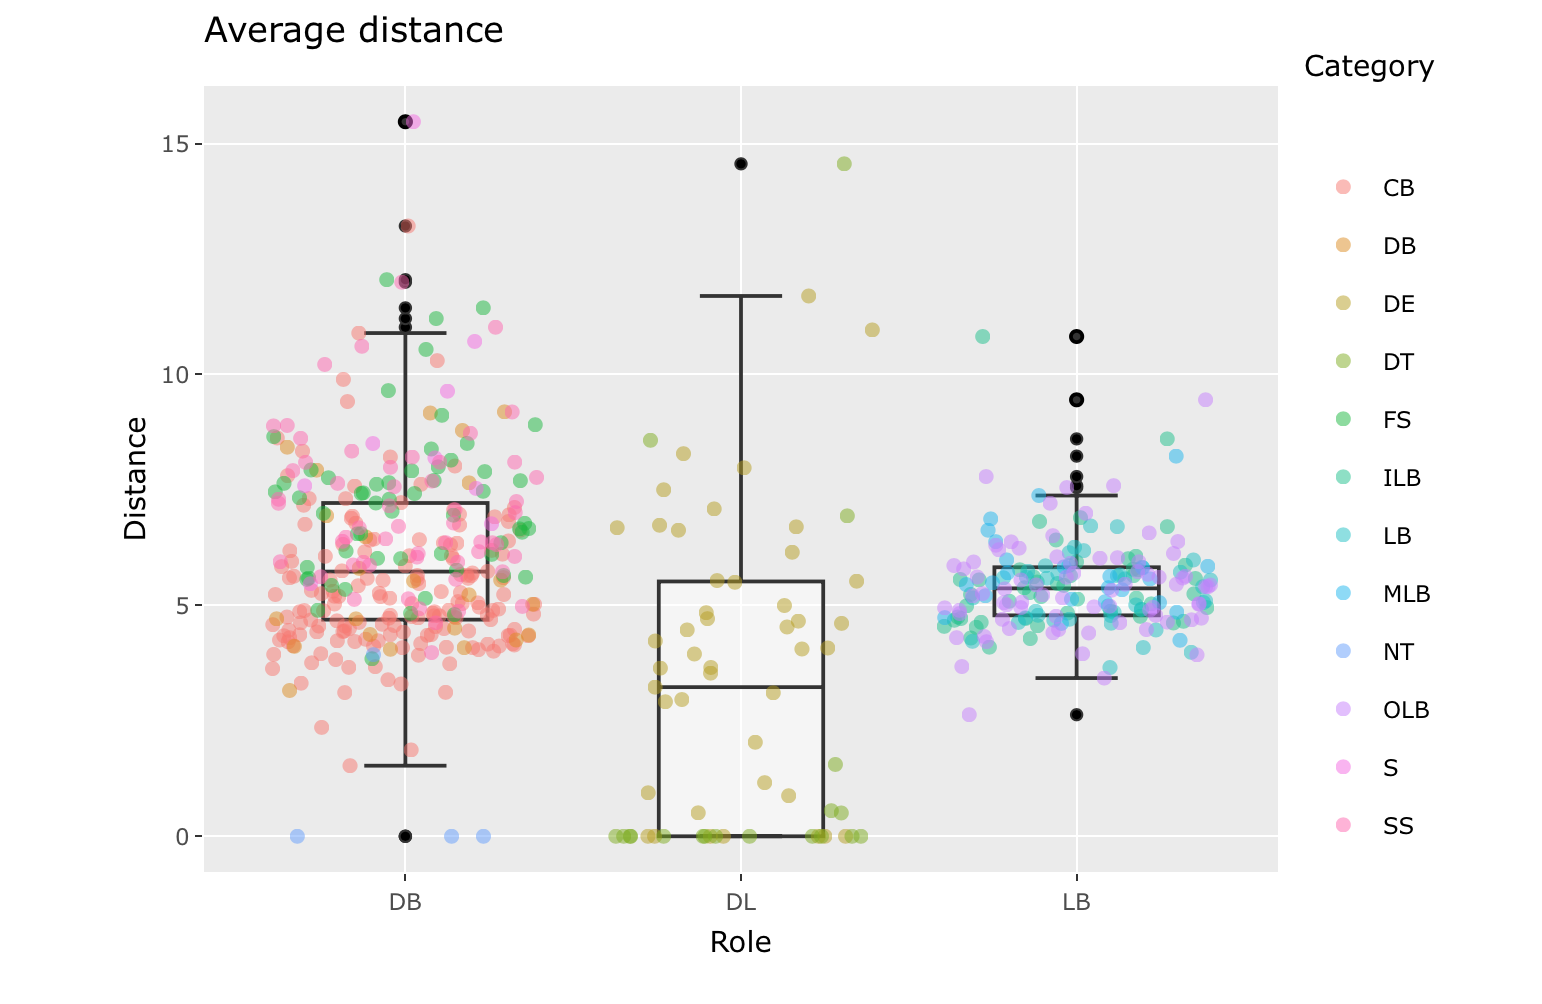


По выводу из 1 части самые лучшие игроки защиты относились к 2, 6 и 7 кластерам по points_cnt. Проверим значимость этой кластеризации

Выведем топ 10 игроков с учетом кластеризации. Для этого сделаем сортировку по points, minDist и averege

In [11]:
sorted_players.loc[:, 'position':'average'].head(10)

,position,displayName,points,cnt,BMI,points_cnt,points_bmi,maxDist,minDist,average
521,DE,Cameron Jordan,-79,21,34.930921,7,5,17.748037,1.462498,7.978469
378,DE,J.J. Watt,-67,16,34.148086,7,5,2.764306,0.000000,1.161061
410,DE,Calais Campbell,-65,14,32.953125,7,5,25.986699,0.000000,6.627990
236,OLB,Devon Kennard,-63,8,31.994311,5,5,9.169215,3.001483,5.699602
470,DT,Adam Butler,-58,7,35.570923,5,5,0.000000,0.000000,0.000000
560,DT,Akiem Hicks,-54,13,42.842105,7,3,0.000000,0.000000,0.000000
34,OLB,Terrell Suggs,-54,16,33.119111,7,5,10.027763,2.282317,5.630527
438,DE,Myles Garrett,-53,17,33.105263,7,5,6.764326,2.643672,4.228331
444,DE,Bradley Chubb,-51,16,33.470395,7,5,5.523164,1.031746,3.106548
377,DE,Jadeveon Clowney,-47,12,30.235284,7,6,14.121023,3.906137,6.681411


Самый важный класс игроков абсолютным большинством попал в 7 кластер. Лучшим оказался DE **Cameron Jordan** и **J.J. Watt**

Если мы обратимся к статистике по игрокам защиты за 2018 год, мы увидим, что лучший был Aaron Donald, следующим идет J.J.Watt. Однако Аарона нет в наших данных, и статистики о нем таже нет. [Сайт NFL](https://www.nfl.com/stats/player-stats/category/tackles/2018/reg/all/defensivesacks/desc)

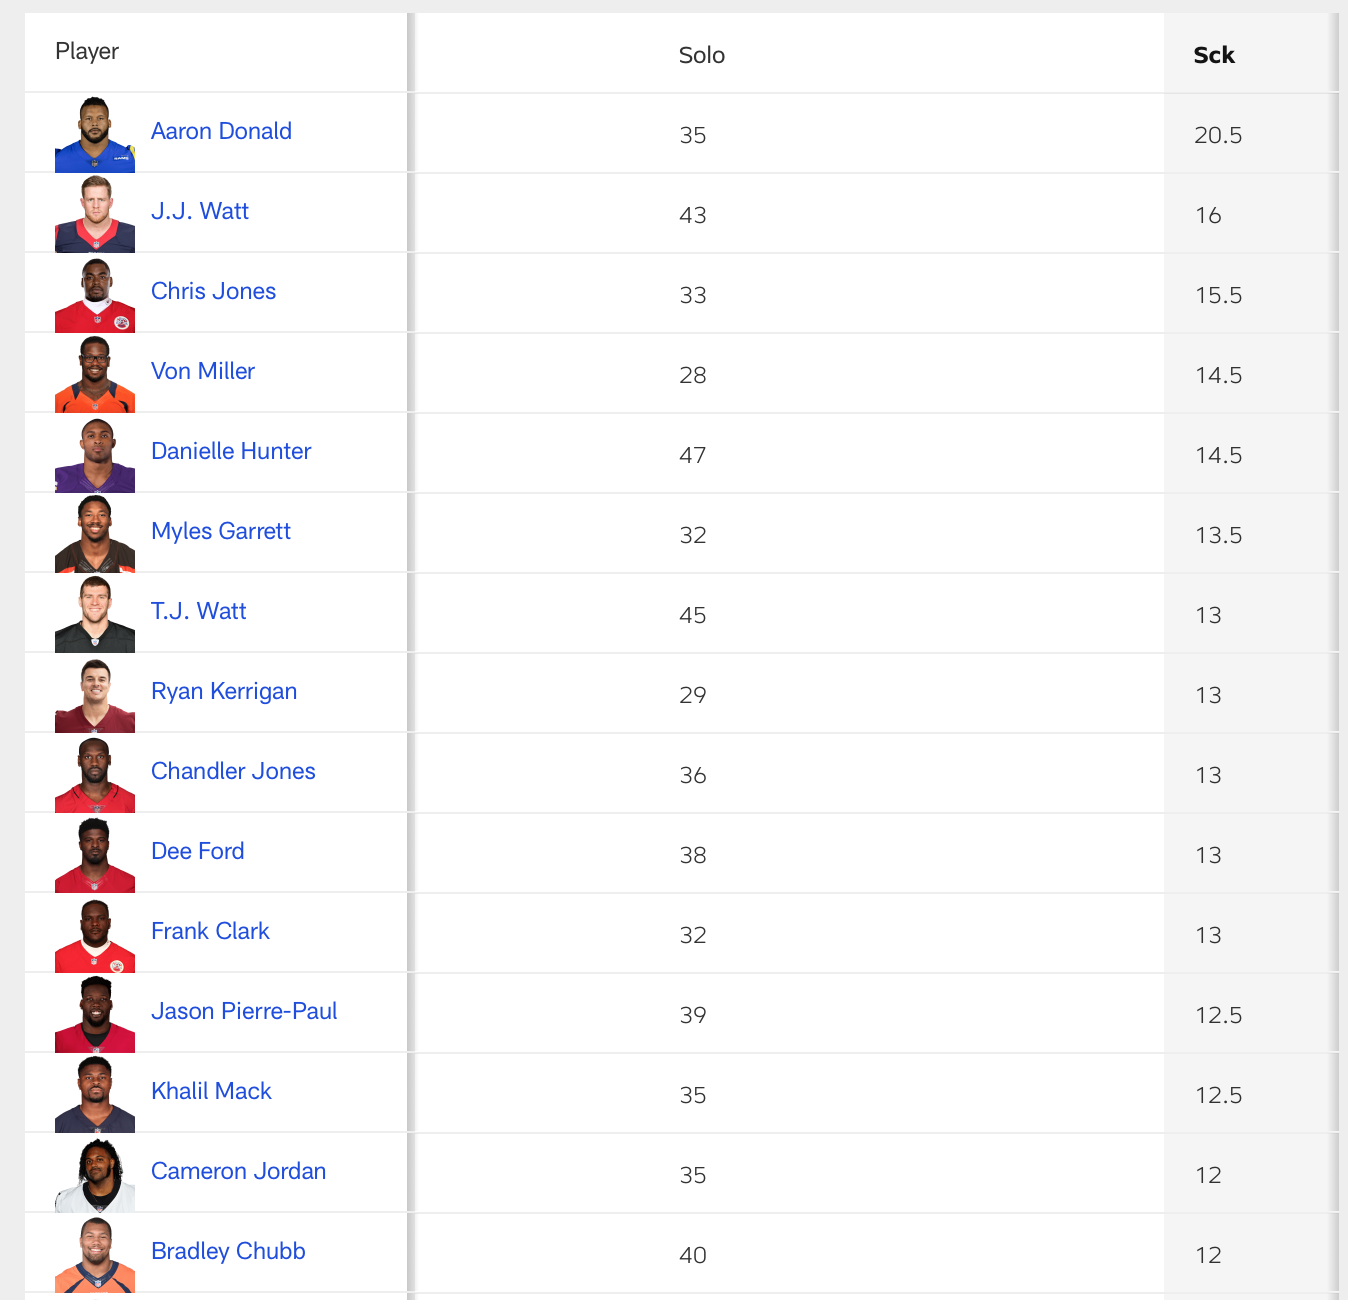

Другая статистика, которая показалась нам интересной – это рейтинг игры Madden NFL 21 от компании EA. Для моделирования игры там так же используются методы анализа реальных матчей.

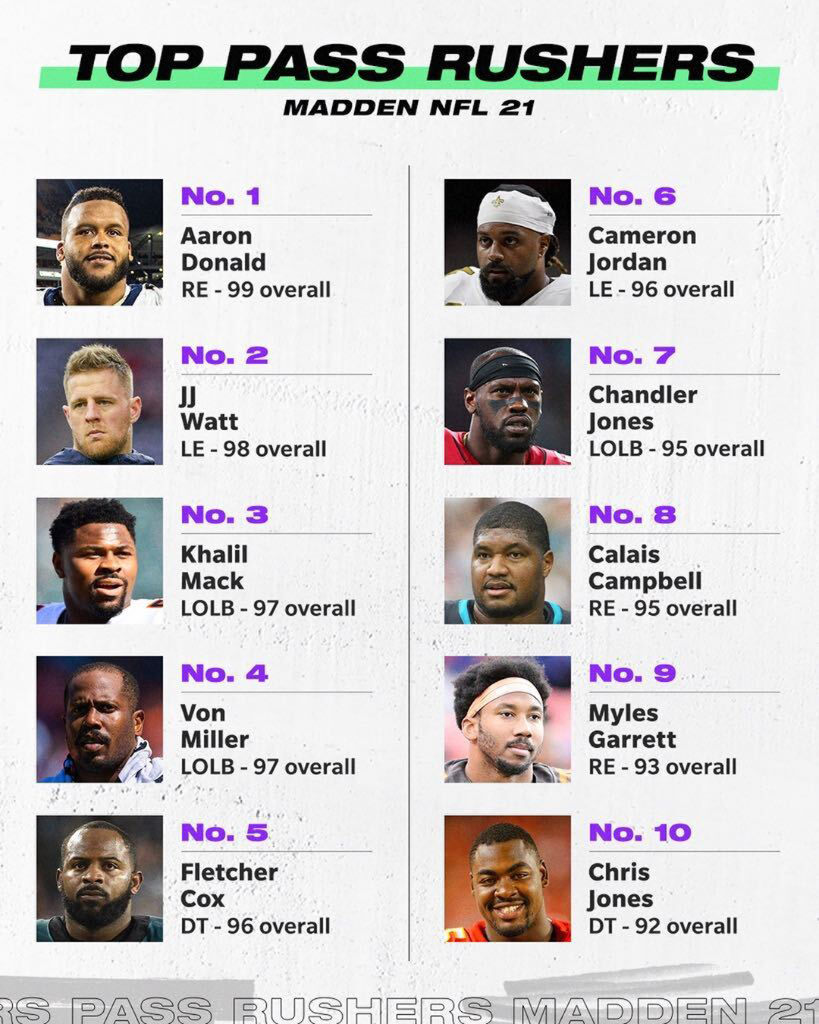

Таким образом модель поведения игрока во многом влияет на эффективность игрока. Для защитника способность хорошо закрывать и преследовать соперника является важными показателями полезности игрока. 

<a href="#">Следующая страница<a>

<p></p>

<a href="page5.html">Предыдущая страница<a>

<p></p><p>